In [1]:
# This demo covers a multi-class classification problem. This is 
# somewhat more complicated, so the UI is slightly different, but 
# the general ideas are the same. The APIs may be used in the same
# way; only the metrics, tables, plots and other information 
# presented will be different.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.insert(0, "..")
from threshold_tuner import ClassificationThesholdTuner

In [3]:
NUM_ROWS = 100_000

In [4]:
# Simple example with 3 true classes, each covering 1/3 of the records. 
# The predictions are accurate, but not perfect. The predictions for the
# true class (once normalized) tend to be fairly low. 
def generate_data_3a():
    num_rows_per_class = NUM_ROWS // 3
    np.random.seed(0)
    d = pd.DataFrame({"Y": ['A']*num_rows_per_class + ['B']*num_rows_per_class + ['C']*num_rows_per_class,
                  "Pred_Proba_A": 
                      np.random.normal(0.9, 0.3, num_rows_per_class).tolist() + \
                      np.random.normal(0.1, 0.3, num_rows_per_class * 2).tolist(),
                  "Pred_Proba_B": 
                      np.random.normal(0.1, 0.3, num_rows_per_class).tolist() + \
                      np.random.normal(0.9, 0.3, num_rows_per_class).tolist() + \
                      np.random.normal(0.1, 0.3, num_rows_per_class).tolist(),
                  "Pred_Proba_C": 
                      np.random.normal(0.1, 0.3, num_rows_per_class*2).tolist() + \
                      np.random.normal(0.9, 0.3, num_rows_per_class).tolist()                    
                 })
    d['Y'] = d['Y'].astype(str)
    return d, ['A', 'B', 'C']

# Similar to 3a, but here we have a logical default class
def generate_data_3b():
    num_rows_for_default = int(NUM_ROWS * 0.9) 
    num_rows_per_class = (NUM_ROWS - num_rows_for_default) // 2
    np.random.seed(0)
    d = pd.DataFrame({"Y": ['No Attack']*num_rows_for_default + ['Attack A']*num_rows_per_class + ['Attack B']*num_rows_per_class,
                  "Pred_Proba No Attack": 
                      np.random.normal(0.7, 0.3, num_rows_for_default).tolist() + \
                      np.random.normal(0.5, 0.3, num_rows_per_class * 2).tolist(),
                  "Pred_Proba Attack A": 
                      np.random.normal(0.1, 0.3, num_rows_for_default).tolist() + \
                      np.random.normal(0.9, 0.3, num_rows_per_class).tolist() + \
                      np.random.normal(0.1, 0.3, num_rows_per_class).tolist(),
                  "Pred_Proba Attack B": 
                      np.random.normal(0.1, 0.3, num_rows_for_default).tolist() + \
                      np.random.normal(0.1, 0.3, num_rows_per_class).tolist() + \
                      np.random.normal(0.9, 0.3, num_rows_per_class).tolist()                    
                 })
    d['Y'] = d['Y'].astype(str)
    return d, ['No Attack', 'Attack A', 'Attack B']

# Generate a dataset with 10 classes.
def generate_data_10():
    num_rows_for_default = int(NUM_ROWS * 0.9)
    num_rows_per_class = (NUM_ROWS - num_rows_for_default) // 9
    np.random.seed(0)
    d = pd.DataFrame({
        "Y": ['No Attack']*num_rows_for_default + ['Attack 1']*num_rows_per_class + ['Attack 2']*num_rows_per_class +\
             ['Attack 3']*num_rows_per_class + ['Attack 4']*num_rows_per_class + ['Attack 5']*num_rows_per_class + \
             ['Attack 6']*num_rows_per_class + ['Attack 7']*num_rows_per_class + ['Attack 8']*num_rows_per_class + \
             ['Attack 9']*num_rows_per_class,
        "Pred_Proba No Attack":
            np.random.normal(0.7, 0.3, num_rows_for_default).tolist() + \
            np.random.normal(0.5, 0.3, num_rows_per_class * 9).tolist(),
    })

    for i in range(9):
        num_rows_classes_before = num_rows_per_class * (i)
        num_rows_classes_after = num_rows_per_class * (9-i-1)

        d[f"Pred_Proba Attack {i+1}"] = \
          np.random.normal(0.1, 0.3, num_rows_for_default + num_rows_classes_before).tolist() + \
          np.random.normal(0.9, 0.3, num_rows_per_class).tolist() + \
          np.random.normal(0.1, 0.3, num_rows_classes_after).tolist()

    d['Y'] = d['Y'].astype(str)
    return d, ['No Attack', 'Attack 1', 'Attack 2', 'Attack 3', 'Attack 4', 'Attack 5', 'Attack 6', 'Attack 7', 'Attack 8', 'Attack 9']


# Test with 3 classes

In [5]:
d, target_classes = generate_data_3b()

In [6]:
target_classes

['No Attack', 'Attack A', 'Attack B']

In [7]:
# Ensure the probabilities are between 0.0 and 1.0. It is possible for the scores coming
# from MinMaxScaler to be slighly outside this range.

scaler= MinMaxScaler()
proba_cols = [x for x in d.columns if "Proba" in x]

for col_name in proba_cols:
    d[col_name] = scaler.fit_transform(d[col_name].values.reshape(-1, 1)).reshape(1, -1)[0]
    d[col_name] = [x if x <= 1.0 else 1.0 for x in d[col_name]]
    d[col_name] = [x if x >= 0.0 else 0.0 for x in d[col_name]]
  
   
# Ensure the probabilities sum to 1.0
d['Sum'] = d[proba_cols].sum(axis=1)
for col_name in proba_cols:
    d[col_name] = d[col_name] / d['Sum']
d['Sum'] = d[proba_cols].sum(axis=1)
d = d.drop(columns=["Sum"])

In [8]:
# Set the Binary prediction column based on the 
# class with the highest prediction (no threshold used).

def set_class_prediction(d):    
    max_cols = d[proba_cols].idxmax(axis=1)
    max_cols = [x[len("Pred_Proba_"):] for x in max_cols]
    return max_cols   

d['Pred'] = set_class_prediction(d)   
d

,Y,Pred_Proba No Attack,Pred_Proba Attack A,Pred_Proba Attack B,Pred
0,No Attack,0.489025,0.255974,0.255001,No Attack
1,No Attack,0.378541,0.354622,0.266837,No Attack
2,No Attack,0.474422,0.305459,0.220119,No Attack
3,No Attack,0.500712,0.261060,0.238228,No Attack
4,No Attack,0.529807,0.282731,0.187462,No Attack
...,...,...,...,...,...
99995,Attack B,0.277859,0.294964,0.427177,Attack B
99996,Attack B,0.175582,0.317689,0.506728,Attack B
99997,Attack B,0.322295,0.289397,0.388308,Attack B
99998,Attack B,0.223581,0.223844,0.552574,Attack B


In [9]:
d['Pred'].value_counts()

No Attack    65921
Attack A     21879
Attack B     12200
Name: Pred, dtype: int64

# Test the visualizations

In [10]:
tuner = ClassificationThesholdTuner()

,Metric,No Attack,Attack A,Attack B,Macro
0,Precision,0.985316,0.208053,0.342049,0.511806
0,Recall,0.721700,0.910400,0.834600,0.822233
0,F1,0.833153,0.338703,0.485233,0.552363


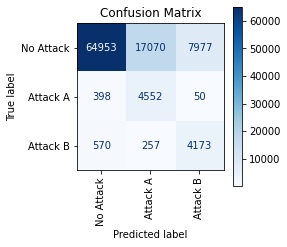

In [11]:
# Simple output based on the predicted classes

tuner.print_stats_labels(
    y_true=d["Y"], 
    target_classes=target_classes,
    y_pred=d["Pred"])

,Metric,No Attack,Attack A,Attack B,Macro
0,Precision,0.985316,0.208053,0.342049,0.511806
0,Recall,0.721700,0.910400,0.834600,0.822233
0,F1,0.833153,0.338703,0.485233,0.552363


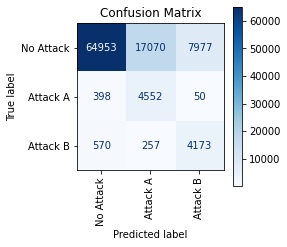

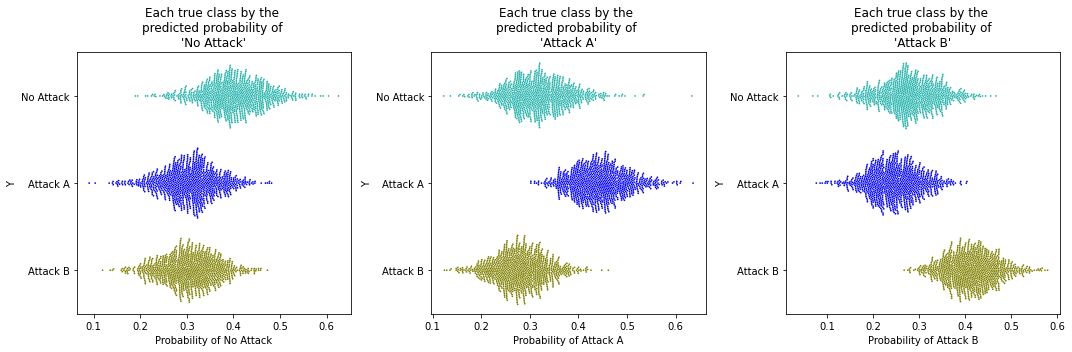

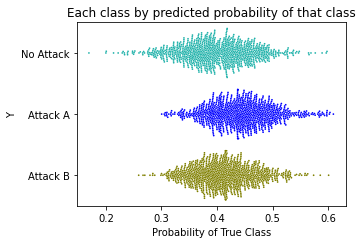

In [12]:
# Simple output based on the predicted probabilities for each class
# Here, the predictions tend to be highest for the true class, but only
# about 0.4 to 0.5, while the other two classes will have probabilities 
# around 0.25. 

tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes,
    y_pred_proba=d[proba_cols].values,
    default_class=None,
    thresholds=None
)    

,Metric,No Attack,Attack A,Attack B,Macro
0,Precision,0.963077,0.355783,0.595435,0.638099
0,Recall,0.900167,0.777600,0.589600,0.755789
0,F1,0.930560,0.488197,0.592503,0.670420


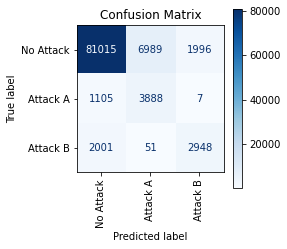

......................................................................................


## Examining the results in terms of class 'No Attack' (the default class) vs all

,Metric,Score
0,Brier Score,0.337894
1,AUROC,0.863451


Brier score and AUROC calculated based on predicting 'No Attack', vs not 'No Attack', so calculated as a two-class problem.

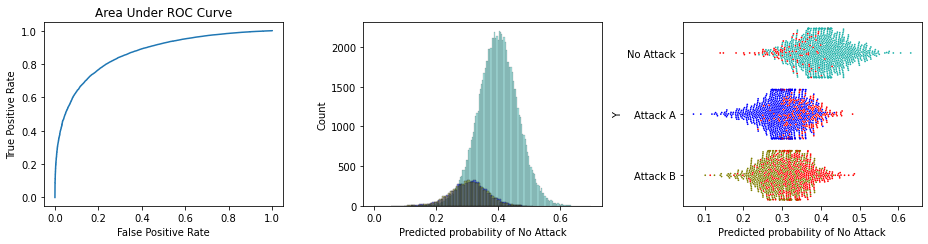

......................................................................................


## Examining the results in terms of class 'Attack A' vs all

,Metric,Score
0,Brier Score,0.114562
1,AUROC,0.942711


Brier score and AUROC calculated based on predicting 'Attack A', vs not 'Attack A', so calculated as a two-class problem.

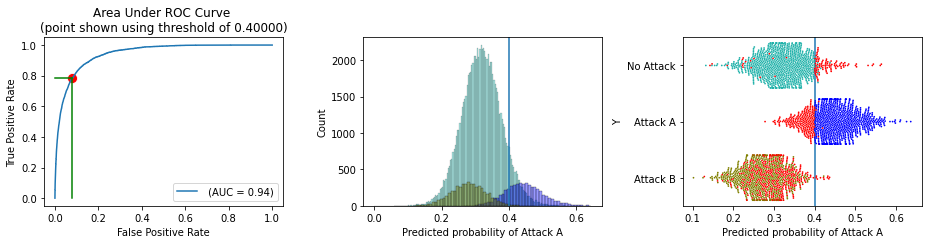

......................................................................................


## Examining the results in terms of class 'Attack B' vs all

,Metric,Score
0,Brier Score,0.094900
1,AUROC,0.954228


Brier score and AUROC calculated based on predicting 'Attack B', vs not 'Attack B', so calculated as a two-class problem.

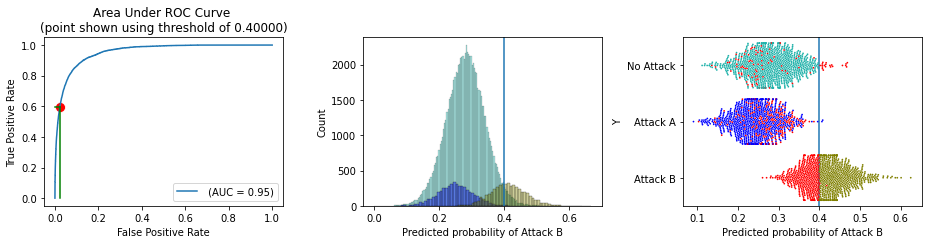

In [13]:
# Here we demonstrate the same, but providing a set of thresholds. 
# As this is multi-class classification, it's necessary to 
# also set a default class. The threshold for the default
# class is not used and is usually set to 0.0. This sets
# the thresholds for the other 2 classes to 0.4 (selected
# somewhat randomly and just for demonstration).

tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes, 
    y_pred_proba=d[proba_cols].values,
    default_class='No Attack',
    thresholds=[0.0, 0.4, 0.4]
)  

# Tools to help adjust the threshold

Displaying thresholds where a common threshold is applied to all classes (other than the default class). Red indicates misclassified records.

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.19s/it]


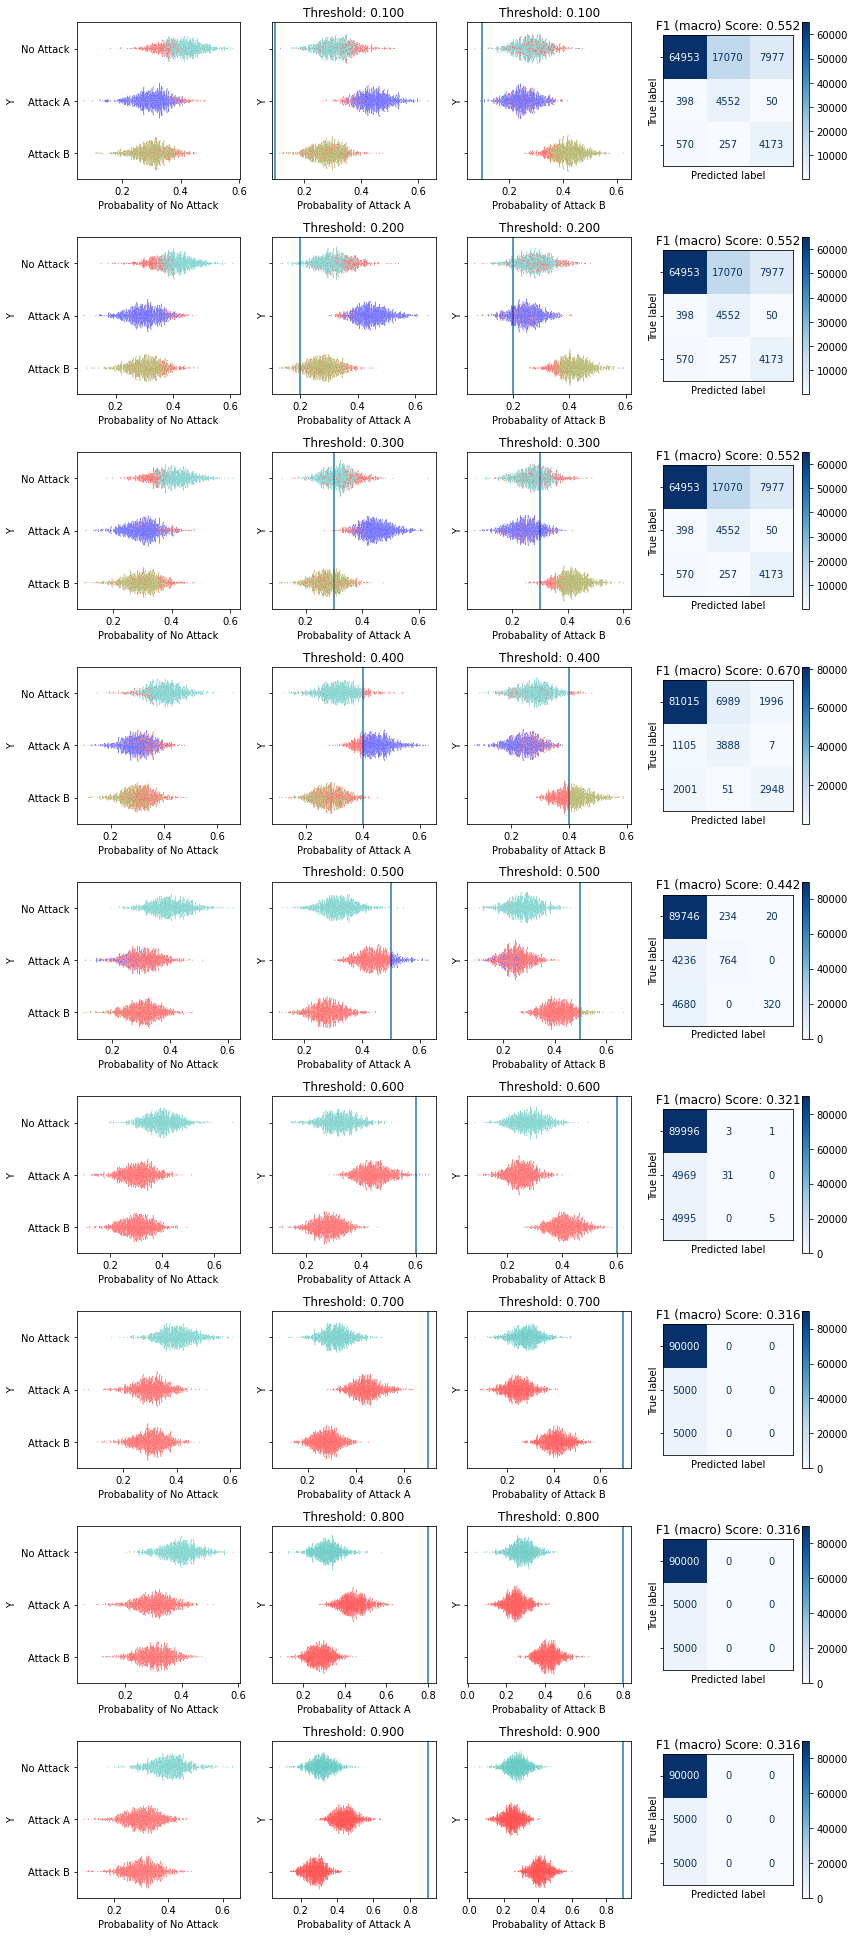

In [14]:
# View the effect of different thresholds for a specified
# set of thresholds. This uses the default set of 0.1, 0.2,
# 0.3...up to 0.9.
# This is multiclass classification, so it is necessary to 
# set the default class. 

tuner.plot_by_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d[proba_cols].values,
    default_class='No Attack'
)

In [15]:
# Notes:

# As the threshold is increseased, more and more of the records where the true
# class is the default (No Attack) are labelled correctly. 

# When the threshold is quite low, such as 0.1, then of those records where the 
# true class is the default, only those with the highest predicted probability of 
# the class being No Attack (about the top half) were predicted correctly. 

# Once the threshold is set above 0.6, everything is predicted as the default class,
# so all cases where the ground truth is the default class are correct and all others
# are incorrect. 

# Attack A and B are generally predicted correctly when using low thresholds,
# but mostly incorrectly when using higher thresholds. 

# As expected,, setting the threshold higher meeans prediting the default class 
# more often and missing less of these, though missing more of the other classes. 

In [ ]:
# Allow ClassificationThesholdTuner to identify the best threshold optimizing
# for a specified metric, in this example, f1 score (macro).
# The threshold for the default class will always be set to 0.0.

from sklearn.metrics import f1_score

best_thresholds = tuner.tune_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d[proba_cols].values,
    metric=f1_score,
    average='macro',
    higher_is_better=True,
    default_class='No Attack',
    max_iterations=5
)
best_thresholds

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

In [ ]:
tuned_pred = tuner.get_predictions(target_classes, d[proba_cols], 'No Attack', best_thresholds)

# Display the first 10 predictions
tuned_pred[:10]

In [ ]:
# Call print_stats_proba() again, this time with the best thresholds.
# The macro F1 score has improved from about 0.44 to 0.68 (results
# will vary slightly from run to run).

tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes, 
    y_pred_proba=d[proba_cols].values,
    default_class='No Attack',
    thresholds=best_thresholds
) 

# Test with 10 classes

In [ ]:
d, target_classes = generate_data_10()

In [ ]:
scaler= MinMaxScaler()
proba_cols = [x for x in d.columns if "Proba" in x]

for col_name in proba_cols:
    d[col_name] = scaler.fit_transform(d[col_name].values.reshape(-1, 1)).reshape(1, -1)[0]
    d[col_name] = [x if x <= 1.0 else 1.0 for x in d[col_name]]
    d[col_name] = [x if x >= 0.0 else 0.0 for x in d[col_name]]
  
   
# Ensure the probabilities sum to 1.0
d['Sum'] = d[proba_cols].sum(axis=1)
for col_name in proba_cols:
    d[col_name] = d[col_name] / d['Sum']
d['Sum'] = d[proba_cols].sum(axis=1)
d = d.drop(columns=["Sum"])

In [ ]:
target_classes

In [ ]:
tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes,
    y_pred_proba=d[proba_cols].values,
    default_class=None,
    thresholds=None
)    

In [ ]:
# This shows an example if 0.1 (selected randomly for this demonstration)
# were used as the threshold for all classes (other than the default).
# We can see in the plots, 0.1 is likely too low for most classes. 

tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes, 
    y_pred_proba=d[proba_cols].values,
    default_class='No Attack',
    thresholds=[0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
)  

In [ ]:
# Call plot_by_threshold() with the default settings, which plots
# using thresholds of 0.1, 0.2, ... 0.9.

tuner.plot_by_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d[proba_cols].values,
    default_class='No Attack'
)

In [ ]:
from sklearn.metrics import f1_score

best_thresholds = tuner.tune_threshold(
    y_true=d['Y'], 
    target_classes=target_classes,
    y_pred_proba=d[proba_cols].values,
    metric=f1_score,
    average='macro',
    higher_is_better=True,
    default_class='No Attack',
    max_iterations=5
)
best_thresholds

In [ ]:
tuner.print_stats_proba(
    y_true=d["Y"], 
    target_classes=target_classes, 
    y_pred_proba=d[proba_cols].values,
    default_class='No Attack',
    thresholds=best_thresholds
) 